In [10]:
# 1) Install and import libraries
# (If you don't have dependencies installed, run: pip install -r requirements.txt)
import sys
from pathlib import Path

try:
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import os
except Exception as e:
    raise ImportError("Missing packages; install with: pip install -r requirements.txt. Original error: " + str(e))

# Optional libraries
PYVIS_AVAILABLE = True
PLOTLY_AVAILABLE = True
try:
    from pyvis.network import Network
except Exception:
    PYVIS_AVAILABLE = False
try:
    import plotly.graph_objects as go
except Exception:
    PLOTLY_AVAILABLE = False

print(f"pyvis available: {PYVIS_AVAILABLE}, plotly available: {PLOTLY_AVAILABLE}")

# Plot settings
%matplotlib inline
plt.rcParams.update({"figure.figsize": (12, 8)})

pyvis available: False, plotly available: False


In [11]:
# 2) Select dataset and visualization goal

# We'll load the real mention graph if possible. If you prefer, you can switch to synthetic graphs below.

# Option: use synthetic graphs for testing
USE_SYNTHETIC = False
SYNTH_TYPE = "barabasi"  # or 'erdos'

if USE_SYNTHETIC:
    if SYNTH_TYPE == "barabasi":
        G = nx.barabasi_albert_graph(100, 2, seed=42).to_directed()
    else:
        G = nx.erdos_renyi_graph(100, 0.05, seed=42).to_directed()
else:
    G = None

G is None

True

In [12]:
# 3) Load or generate graph data

# Load from GraphML if available
graph_path = Path("/workspaces/test/outputs/network.graphml")
if graph_path.exists():
    print("Loading graph from outputs/network.graphml")
    G = nx.read_graphml(str(graph_path))
    # networkx reads GraphML nodes as strings; ensure directed
    if not isinstance(G, nx.DiGraph):
        G = G.to_directed()
else:
    print("GraphML not found; attempting to rebuild from MongoDB")
    from dotenv import load_dotenv
    load_dotenv()
    MONGODB_URI = os.getenv("MONGODB_URI") or os.getenv("MONGODB_CONNECT")
    if not MONGODB_URI:
        raise RuntimeError("MongoDB connection not found in env (MONGODB_CONNECT / MONGODB_URI)")
    import pymongo
    client = pymongo.MongoClient(MONGODB_URI)
    coll = client["demo"]["tweet_collection"]

    # Build mention graph similar to scripts/analyze_network.py
    import re
    MENTION_RE = re.compile(r"@([A-Za-z0-9_]{1,15})")
    G = nx.DiGraph()
    for t in coll.find({}, {"author": 1, "text": 1}):
        author = (t.get("author") or "").lower()
        if author == "":
            continue
        mentions = [m.lower() for m in MENTION_RE.findall(t.get("text") or "")]
        for m in mentions:
            if m == author:
                continue
            if not G.has_node(author):
                G.add_node(author)
            if not G.has_node(m):
                G.add_node(m)
            if G.has_edge(author, m):
                G[author][m]["weight"] += 1
            else:
                G.add_edge(author, m, weight=1)

print(f"Loaded graph: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

Loading graph from outputs/network.graphml
Loaded graph: nodes=118, edges=109


Nodes: 118, Edges: 109

Top 10 by in-degree:
laratlarian 22
commanderredexe 5
stretchedwiener 3
allisonperryart 3
nuhre_ 3
rec_a_dork 2
graymattermanga 2
canteverdie 2
dexerto 2
kyansorboi 2

Top 10 by out-degree:
allisonperryart 5
roastchicken3d 5
theworstkirst 5
plundypops 4
theragmancometh 4
bdncamp 4
bluefreezexero 4
cici_artenjoyer 4
0dude00 4
supersnkrdoodle 3


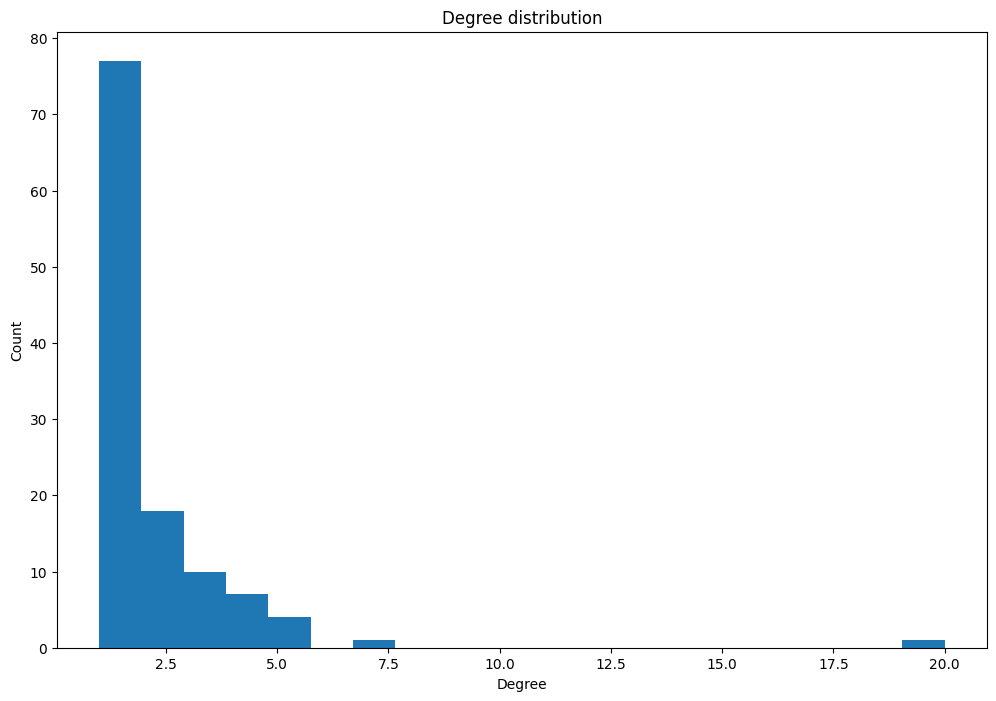

In [13]:
# 4) Basic inspection & preprocessing

# Show top-degree users, degree distribution, and an extract if graph is large.

# Basic stats
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print(f"Nodes: {n_nodes}, Edges: {n_edges}")

# top in-degree and out-degree
in_deg = sorted(G.in_degree(weight="weight"), key=lambda x: x[1], reverse=True)
out_deg = sorted(G.out_degree(weight="weight"), key=lambda x: x[1], reverse=True)

print("\nTop 10 by in-degree:")
for u, d in in_deg[:10]:
    print(u, d)

print("\nTop 10 by out-degree:")
for u, d in out_deg[:10]:
    print(u, d)

# degree distribution histogram
deg = [d for _, d in G.degree()]
plt.hist(deg, bins=20)
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

In [14]:
# 5) Compute graph metrics and centrality

# Centrality measures
degree_cent = nx.degree_centrality(G)
betw = nx.betweenness_centrality(G)

# attach to nodes
nx.set_node_attributes(G, degree_cent, "degree_cent")
nx.set_node_attributes(G, betw, "betweenness")

print("Computed centrality metrics")

Computed centrality metrics


In [15]:
# 6) Apply layout algorithms

pos = nx.spring_layout(G, seed=42)
print("Layout computed")

Layout computed


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

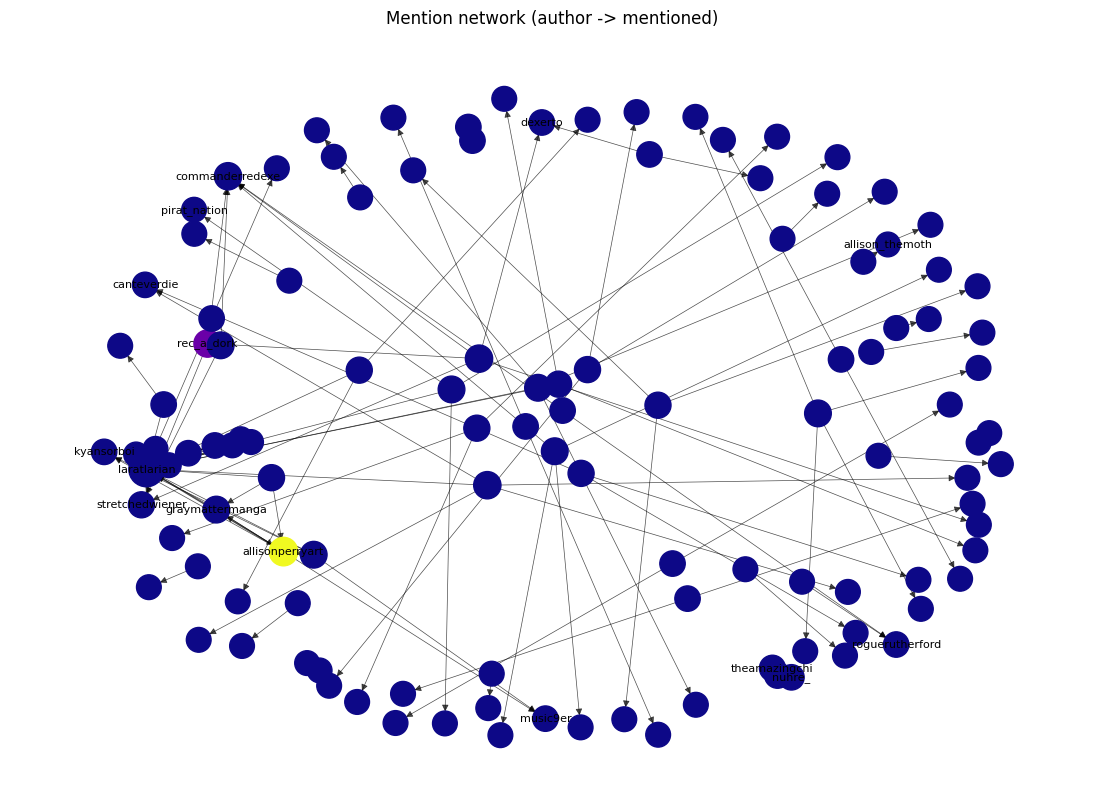

In [16]:
# 7) Static visualization with Matplotlib

output_img = Path("/workspaces/test/outputs/network_notebook.png")
output_img.parent.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(14, 10))

# Node sizes by degree centrality
node_sizes = [300 + 2000 * degree_cent.get(n, 0) for n in G.nodes()]

# Color nodes by betweenness
bet_values = [betw.get(n, 0) for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=bet_values, cmap=plt.cm.plasma)
# Edge widths by weight
edge_widths = [max(0.5, d.get('weight', 1) * 0.5) for _, _, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
# label top nodes only
top_nodes = [u for u, _ in in_deg[:15]]
nx.draw_networkx_labels(G, pos, labels={n: n for n in top_nodes}, font_size=8)

plt.title('Mention network (author -> mentioned)')
plt.axis('off')
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), label='betweenness (normalized)')
plt.savefig(output_img, bbox_inches='tight', dpi=150)
plt.show()
print(f"Saved image to {output_img}")

In [17]:
# 8) Interactive visualization with Plotly (optional)

if PLOTLY_AVAILABLE:
    edge_x = []
    edge_y = []
    for e in G.edges():
        x0, y0 = pos[e[0]]
        x1, y1 = pos[e[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]

    node_text = [f"{n}<br>deg={G.degree(n)}<br>deg_cent={degree_cent.get(n,0):.4f}" for n in G.nodes()]

    edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5, color='#888'), hoverinfo='none')
    node_trace = go.Scatter(
        x=node_x, y=node_y, mode='markers', hoverinfo='text', text=node_text,
        marker=dict(
            showscale=True,
            colorscale='YlOrRd',
            color=[betw.get(n,0) for n in G.nodes()],
            size=[5 + 30 * degree_cent.get(n,0) for n in G.nodes()],
            colorbar=dict(title='betweenness')
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest'))
    html_path = Path('/workspaces/test/outputs/network_plotly.html')
    fig.write_html(str(html_path))
    print(f"Saved interactive Plotly HTML to {html_path}")
else:
    print("Plotly not available; skip Plotly interactive export.")

Plotly not available; skip Plotly interactive export.


In [18]:
# 9) Interactive browser visualization with PyVis (optional)

if PYVIS_AVAILABLE:
    py = Network(height='800px', width='100%', notebook=True, bgcolor='#ffffff')
    # add nodes with sizes/labels
    for n in G.nodes():
        py.add_node(n, label=n, title=f"deg={G.degree(n)}", value=degree_cent.get(n,0))
    for a,b,d in G.edges(data=True):
        py.add_edge(a, b, value=d.get('weight',1))

    py.force_atlas_2based()
    html_path = '/workspaces/test/outputs/network_pyvis.html'
    py.save_graph(html_path)
    print(f"Saved interactive PyVis HTML to {html_path}")
else:
    print("PyVis not available; skip PyVis export.")

PyVis not available; skip PyVis export.


In [19]:
# 10) Done
print('Completed notebook; check outputs/ for saved visualizations.')

Completed notebook; check outputs/ for saved visualizations.
